## 本分对xgboost调优参考网易云课堂教程全栈数据工程师养成攻略的xgboost内容  （https://github.com/Honlan/fullstack-data-engineer/blob/master/data/Parameter_Tuning_XGBoost_with_Example/XGBoost_models.ipynb)

In [43]:
import pandas as pd
import datetime
import csv
import numpy as np
import xgboost as xgb
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn import cross_validation, metrics
from matplotlib import pylab as plt
plot = True
goal = 'Sales'
myid = 'Id'

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# 数据导入

In [44]:
def get_data():
    store = pd.read_csv('./store.csv')
    train_org = pd.read_csv('./train.csv',dtype={'StateHoliday':pd.np.string_})
    test_org = pd.read_csv('./test.csv',dtype={'StateHoliday':pd.np.string_})
    train = pd.merge(train_org,store,on='Store',how='left')
    test = pd.merge(test_org,store,on='Store',how='left')
    feature = test.columns.tolist()
    numerics = ['int16','int32','int64','float16','float32','float64']
    feature_numeric = test.select_dtypes(include = numerics).columns.tolist()
    feature_non_numeric = [f for f in feature if f not in feature_numeric]
    return (train,test,feature,feature_non_numeric)

# 数据处理

In [45]:
def process_data(train,test,features,features_no):
    train = train[train['Open']==1]
    
    test = test[test['Open']==1]
    for rossm in [train,test]:
        rossm['year'] = rossm.Date.apply(lambda x: int(x.split('-')[0]))
        rossm['month']= rossm.Date.apply(lambda x: int(x.split('-')[1]))
        rossm['day']  = rossm.Date.apply(lambda x: int(x.split('-')[2]))

        rossm['promojan'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jan' in x else 0)
        rossm['promofeb'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Feb' in x else 0)
        rossm['promomar'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Mar' in x else 0)
        rossm['promoapr'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Apr' in x else 0)
        rossm['promomay'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'May' in x else 0)
        rossm['promojun'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jun' in x else 0)
        rossm['promojul'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jul' in x else 0)
        rossm['promoaug'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Aug' in x else 0)
        rossm['promosep'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Sep' in x else 0)
        rossm['promooct'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Oct' in x else 0)
        rossm['promonov'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Nov' in x else 0)
        rossm['promodec'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Dec' in x else 0)
    
    day_dummies = pd.get_dummies(train['DayOfWeek'],prefix='Day')
    day_dummies.drop(['Day_7'],axis=1,inplace=True)  #删除周日的数据
    train = train.join(day_dummies)

    
    day_dummies_test = pd.get_dummies(test['DayOfWeek'],prefix='Day')
    day_dummies_test.drop(['Day_7'],axis=1,inplace=True)  #删除周日数据
    test = test.join(day_dummies_test)
    
    noisy_features = [myid,'Date','Store']
    features = [c for c in features if c not in noisy_features]
    features_non_numeric = [c for c in features_no if c not in noisy_features]
    features.extend(['year','month','day'])
    class DataFrameInputer(TransformerMixin):
        def __init__(self):
                """
                """
        def fit(self,X,y=None):
            self.fill = pd.Series([X[c].value_counts().index[0] 
                                  if X[c].dtype==np.dtype('O') 
                                   else X[c].mean() for c in X],index = X.columns)
            return self
        def transform(self,X,y=None):
            return X.fillna(self.fill)
        
    train = DataFrameInputer().fit_transform(train)
    test  = DataFrameInputer().fit_transform(test)
        
    le = LabelEncoder()
    for col in features:
        le.fit(list(train[col])+list(test[col]))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
    scaler = StandardScaler()
    for col in set(features) - set(features_no) - set([]):
        try:
            scaler.fit(list(train[col])+list(test[col]))
        except:
            print(col)
        train[col] = scaler.transform(train[col])
        test[col] = scaler.transform(test[col])
    return (train,test,features,features_no)    
       
    

# train,test 数据获取

In [46]:
train,test,features,features_non_numeric = get_data()

train,test,features,features_non_numeric = process_data(train,test,features,features_non_numeric)
a1 = train.columns
a2 = ['Date','Sales','Customers','DayOfWeek']
a1 = [f for f in a1 if f not in a2]
# XGB_native(train,test,a1,features_non_numeric)
rossm_train = dict(list(train.groupby('Store')))
rossm_test = dict(list(test.groupby('Store')))

# 查看模型ntree数量和准确率函数

In [31]:
def modelfit(xgb1,train,test,features,useTranCv=True,cv_folds = 6,early_stopping_rounds = 50):
    if useTranCv:
        xgb_param = xgb1.get_xgb_params()
        xgtrain = xgb.DMatrix(train[features].values,label=train[goal])
        xgtest = xgb.DMatrix(train[features].values)
        cvresult = xgb.cv(xgb_param,xgtrain,num_boost_round=xgb1.get_params()['n_estimators'],nfold=cv_folds,
                    early_stopping_rounds = early_stopping_rounds)
        print(cvresult.shape[0])
        xgb1.set_params(n_estimators = cvresult.shape[0])
        
    xgb1.fit(train[features],train[goal])
    train_predict = xgb1.predict(train[features])
#     train_predprob = xgb1.predict_proba(train[features])[:,1]
    
    print('\n Model Report')
    print('Accuray: %.4g' % metrics.r2_score(train[goal].values,train_predict))
    
    feat_imp = pd.Series(xgb1.booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar',title="feature importances")
    plt.ylabel('feature importance score')

1000

 Model Report
Accuray: 0.9017
0.5


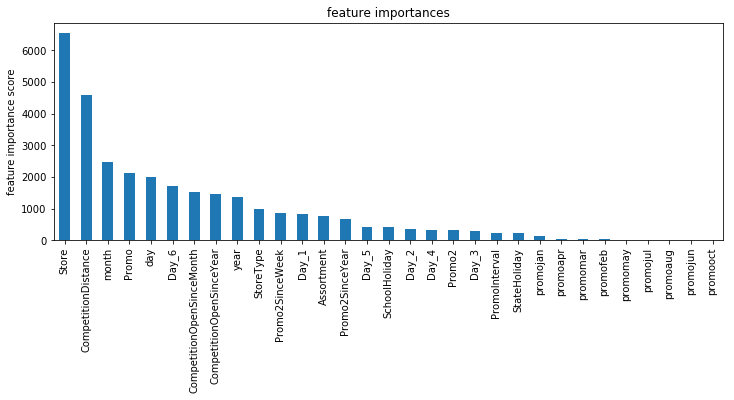

In [48]:
xgb1 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=5,
                        min_child_weight=1,gamma=0,
                        subsample=0.8,colsample_bytree=0.8,
                        nthread=4,scale_pos_weight=1,seed=27
                        )

# modelfit(xgb1,rossm_train[8],rossm_test[8],a1)
modelfit(xgb1,train,test,a1)
print xgb1.base_score

In [60]:
train.sort_values('Store').head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,promosep,promooct,promonov,promodec,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
0,1,0.859568,2015-07-31,5263,555,0.0,1.112230,0,1.964251,2,...,0,0,0,0,0,0,0,0,1,0
739575,1,0.859568,2013-09-06,3836,466,0.0,-0.899095,0,-0.509100,2,...,0,0,0,0,0,0,0,0,1,0
740690,1,0.279410,2013-09-05,3883,465,0.0,-0.899095,0,-0.509100,2,...,0,0,0,0,0,0,0,1,0,0
741805,1,-0.300749,2013-09-04,3343,444,0.0,-0.899095,0,-0.509100,2,...,0,0,0,0,0,0,1,0,0,0
81395,1,-0.880907,2015-05-19,5235,546,0.0,1.112230,0,-0.509100,2,...,0,0,0,0,0,1,0,0,0,0


In [67]:
# store = rossm_train[8]
store = train.sort_values('Store').loc[:1000]
y = store['Sales']
x = store.drop(['Sales','Customers','Date'],axis=1)
X_train,X_test,y_train,y_test = cross_validation.train_test_split(x,y,test_size=0.3)
clf_e = xgb.XGBRegressor()
clf_e.fit(X_train,y_train)

print('XGboost',r2_score(clf_e.predict(X_test),y_test))
print clf_e.base_score

('XGboost', -1.2685671485852055)
0.5


# 对max_depth和min_child_weight调优

In [68]:
param_test1 = {'max_depth':range(7,15,2),'min_child_weight':range(1,6,2)}
xgb1 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,gamma=0,
                        subsample=0.8,colsample_bytree=0.8,
                        nthread=4,scale_pos_weight=1,seed=27
                        )
gsearch1 = GridSearchCV(xgb1,param_grid=param_test1,scoring='r2',n_jobs=-1,iid=False,cv=6)
gsearch1.fit(x,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'max_depth': [7, 9, 11, 13], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [69]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.19681, std: 0.05881, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.20865, std: 0.06232, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.22162, std: 0.05002, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.19996, std: 0.04299, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.20381, std: 0.04756, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.19306, std: 0.05627, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: 0.21312, std: 0.06066, params: {'max_depth': 11, 'min_child_weight': 1},
  mean: 0.20880, std: 0.05513, params: {'max_depth': 11, 'min_child_weight': 3},
  mean: 0.21822, std: 0.05189, params: {'max_depth': 11, 'min_child_weight': 5},
  mean: 0.20689, std: 0.05362, params: {'max_depth': 13, 'min_child_weight': 1},
  mean: 0.20926, std: 0.05678, params: {'max_depth': 13, 'min_child_weight': 3},
  mean: 0.21218, std: 0.05639, params: {'max_depth': 13, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weig

In [70]:
param_test2 = {'max_depth':range(9,15,2),'min_child_weight':[3,4,5]}
xgb2 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,gamma=0,
                        subsample=0.8,colsample_bytree=0.8,
                        nthread=4,scale_pos_weight=1,seed=27
                        )
gsearch2 = GridSearchCV(xgb2,param_grid=param_test2,scoring='r2',n_jobs=-1,iid=False,cv=6)
gsearch2.fit(x,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'max_depth': [9, 11, 13], 'min_child_weight': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [71]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.20381, std: 0.04756, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.21099, std: 0.04503, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: 0.19306, std: 0.05627, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: 0.20880, std: 0.05513, params: {'max_depth': 11, 'min_child_weight': 3},
  mean: 0.21526, std: 0.05175, params: {'max_depth': 11, 'min_child_weight': 4},
  mean: 0.21822, std: 0.05189, params: {'max_depth': 11, 'min_child_weight': 5},
  mean: 0.20926, std: 0.05678, params: {'max_depth': 13, 'min_child_weight': 3},
  mean: 0.20497, std: 0.05626, params: {'max_depth': 13, 'min_child_weight': 4},
  mean: 0.21218, std: 0.05639, params: {'max_depth': 13, 'min_child_weight': 5}],
 {'max_depth': 11, 'min_child_weight': 5},
 0.218219079894197)

In [ ]:
xgb21 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,gamma=0,
                        max_depth=7,min_child_weight=5,
                        subsample=0.8,colsample_bytree=0.8,
                        nthread=4,scale_pos_weight=1,seed=27
                        )
modelfit(xgb4,rossm_train[8],rossm_test[8],a1)

# 对参数gamma进行调优

In [72]:
param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}
xgb3 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,
                        max_depth=2,min_child_weight=6,
                        subsample=0.8,colsample_bytree=0.8,
                        nthread=4,scale_pos_weight=1,seed=27
                        )
gsearch3 = GridSearchCV(xgb3,param_grid=param_test3,scoring='r2',n_jobs=-1,iid=False,cv=6)
gsearch3.fit(x,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [73]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.14032, std: 0.24946, params: {'gamma': 0.0},
  mean: 0.14032, std: 0.24946, params: {'gamma': 0.1},
  mean: 0.14032, std: 0.24946, params: {'gamma': 0.2},
  mean: 0.14032, std: 0.24946, params: {'gamma': 0.3},
  mean: 0.14032, std: 0.24946, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.14031845559046438)

503

 Model Report
Accuray: 0.9511


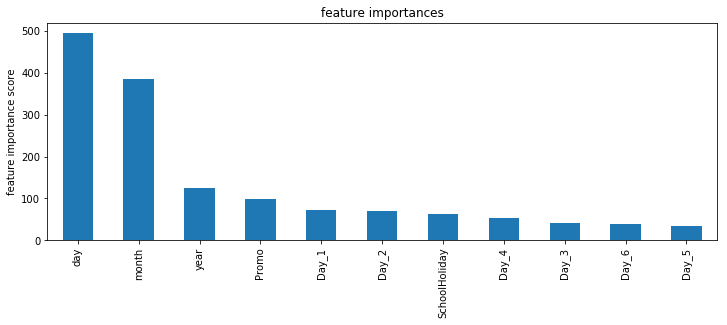

In [74]:
xgb4 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,gamma=0,
                        max_depth=2,min_child_weight=6,
                        subsample=0.8,colsample_bytree=0.8,
                        nthread=4,scale_pos_weight=1,seed=27
                        )
modelfit(xgb4,rossm_train[8],rossm_test[8],a1)

# 对参数subsample进行调优

In [75]:
param_test5 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgb5 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,gamma=0,
                        max_depth=2,min_child_weight=6,
        
                        nthread=4,scale_pos_weight=1,seed=27
                        )
gsearch5 = GridSearchCV(xgb5,param_grid=param_test5,scoring='r2',n_jobs=-1,iid=False,cv=6)
gsearch5.fit(x,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [76]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.17734, std: 0.18462, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.20994, std: 0.10677, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.13807, std: 0.27240, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.16857, std: 0.12931, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.13383, std: 0.28200, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.16163, std: 0.19943, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.11407, std: 0.28366, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.11143, std: 0.28714, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.18528, std: 0.13521, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.16990, std: 0.18204, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.14032, std: 0.24946, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.12903, std: 0.28992, params: {'subsample': 0.9, 'colsample_bytree'

In [77]:
param_test6 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
xgb6 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,gamma=0,
                        max_depth=2,min_child_weight=6,
                        colsample_bytree=0.7,subsample=0.9,
                        nthread=4,scale_pos_weight=1,seed=27
                        )
gsearch6 = GridSearchCV(xgb6,param_grid=param_test6,scoring='r2',n_jobs=-1,iid=False,cv=6)
gsearch6.fit(x,y)

GridSearchCV(cv=6, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [78]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.11143, std: 0.28714, params: {'reg_alpha': 1e-05},
  mean: 0.11143, std: 0.28714, params: {'reg_alpha': 0.01},
  mean: 0.11143, std: 0.28714, params: {'reg_alpha': 0.1},
  mean: 0.11143, std: 0.28713, params: {'reg_alpha': 1},
  mean: 0.12025, std: 0.26591, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 0.12025035410467814)

781

 Model Report
Accuray: 0.9541


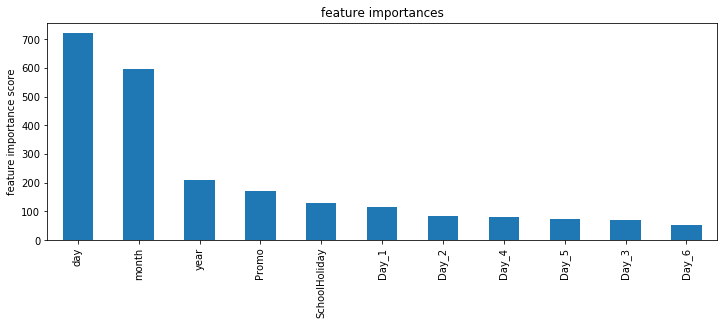

In [79]:
xgb7 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=1000,gamma=0,reg_alpha=1e-05,
                        max_depth=2,min_child_weight=6,
                        colsample_bytree=0.7,subsample=0.9,
                        nthread=4,scale_pos_weight=1,seed=27
                        )
modelfit(xgb7,rossm_train[8],rossm_test[8],a1)

# 对全量数据通过xgboost测试调优

8000

 Model Report
Accuray: 0.8421


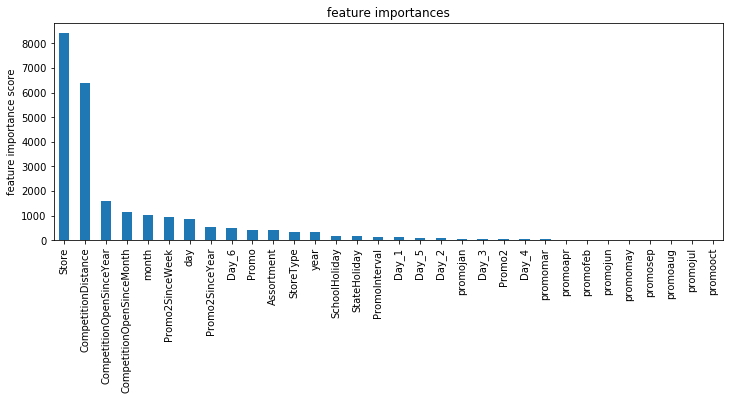

In [80]:
xgb8 = xgb.XGBRegressor(learning_rate=0.1,n_estimators=8000,gamma=0,reg_alpha=1e-05,
                        max_depth=2,min_child_weight=6,
                        colsample_bytree=0.7,subsample=0.9,
                        nthread=4,scale_pos_weight=1,seed=27
                        )
modelfit(xgb8,train,test,a1)